# F1 Racing Analysis

## Research Question

Can we predict F1 race outcomes (points and final position) using qualifying position, circuit characteristics, driver history, and constructor performance?

**Goals**:
- Predict points scored (regression)
- Predict final race position (regression/classification)
- Find most influential factors
- Evaluate with RMSE, MAE, R² for regression; accuracy, precision, recall for classification

---

In [172]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.facecolor'] = 'white'

## 1 - Data Loading and Preprocessing

### The Dataset

Dataset from Kaggle with F1 data from 1950-2024. 14 CSV files covering races, drivers, constructors, circuits, qualifying, lap times, pit stops, and standings.

**Key files**:
- `results.csv` - race results, points, positions
- `races.csv` - race info, dates, circuits
- `qualifying.csv` - qualifying results and grid positions
- `drivers.csv` - driver info
- `constructors.csv` - team info
- `circuits.csv` - circuit details
- `status.csv` - text definitions for status codes
- `constructor_standings.csv` - team standings

### Load the Data

In [173]:
datasets_path = 'datasets'

results = pd.read_csv(os.path.join(datasets_path, 'results.csv'))
races = pd.read_csv(os.path.join(datasets_path, 'races.csv'))
qualifying = pd.read_csv(os.path.join(datasets_path, 'qualifying.csv'))
drivers = pd.read_csv(os.path.join(datasets_path, 'drivers.csv'))
constructors = pd.read_csv(os.path.join(datasets_path, 'constructors.csv'))
circuits = pd.read_csv(os.path.join(datasets_path, 'circuits.csv'))
status = pd.read_csv(os.path.join(datasets_path, 'status.csv'))
constructor_standings = pd.read_csv(os.path.join(datasets_path, "constructor_standings.csv"))


results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


### Merge Datasets

Merge datasets to combine race results with qualifying, driver info, circuits, and constructor data.

In [174]:
df = results.copy().drop(columns=['position', 'positionText']).rename(columns={'positionOrder': 'position'})

qual = qualifying[['raceId', 'driverId', 'position']].rename(columns={'position': 'qualifying_position'})
df = pd.merge(df, qual, on=['raceId', 'driverId'], how='left')

races_circuits = pd.merge(races, circuits[['circuitId', 'circuitRef', 'name', 'country']], on='circuitId', how='left')
df = pd.merge(df, races_circuits[['raceId', 'year', 'round', 'circuitRef', 'country']], on='raceId', how='left')

drivers_df = drivers[['driverId', 'driverRef', 'nationality']].rename(columns={"nationality": "driver_nationality"})
df = pd.merge(df, drivers_df, on='driverId', how='left')

constructors_df = constructors[['constructorId', 'name', 'nationality']].rename(columns={'name': 'constructor_name', 'nationality': 'constructor_nationality'})
df = pd.merge(df, constructors_df, on='constructorId', how='left')

cs = constructor_standings[["raceId", "constructorId", "points", "position", "wins"]]
cs = cs.rename(columns={"points": "constructor_points_standings", "position": "constructor_champ_position", "wins": "constructor_wins_season"})
df = df.merge(cs, on=["raceId", "constructorId"], how="left")

df.head()

,resultId,raceId,driverId,constructorId,number,grid,position,points,laps,time,...,round,circuitRef,country,driverRef,driver_nationality,constructor_name,constructor_nationality,constructor_points_standings,constructor_champ_position,constructor_wins_season
0,1,18,1,1,22,1,1,10.0,58,1:34:50.616,...,1,albert_park,Australia,hamilton,British,McLaren,British,14.0,1.0,1.0
1,2,18,2,2,3,5,2,8.0,58,+5.478,...,1,albert_park,Australia,heidfeld,German,BMW Sauber,German,8.0,3.0,0.0
2,3,18,3,3,7,7,3,6.0,58,+8.163,...,1,albert_park,Australia,rosberg,German,Williams,British,9.0,2.0,0.0
3,4,18,4,4,5,11,4,5.0,58,+17.181,...,1,albert_park,Australia,alonso,Spanish,Renault,French,5.0,4.0,0.0
4,5,18,5,1,23,3,5,4.0,58,+18.014,...,1,albert_park,Australia,kovalainen,Finnish,McLaren,British,14.0,1.0,1.0


### Basic Data Cleaning and Preparation
Make sure that the numeric columns are actually numeric, and filter out the clearly invalid rows. Also add a scored_points and a position_gain row, representing whether or not the driver has scored any points in the race and how many positions driver has gained from start to end.

In [175]:
numeric_cols_to_convert = [
    "position", "grid", "points", "qualifying_position",
    "constructor_points_standings", "constructor_champ_position",
    "constructor_wins_season", "year", "round"
]

for col in numeric_cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df[df["position"].notna() & (df["position"] > 0)]

df = df[df["points"].notna()]

df["scored_points"] = (df["points"] > 0).astype(int)
df['position_gain'] = df['grid'] - df['position']


### Missingness

There are several missing values across different columns:

In [176]:
df.isna().sum()

resultId                            0
raceId                              0
driverId                            0
constructorId                       0
number                              0
grid                                0
position                            0
points                              0
laps                                0
time                                0
milliseconds                        0
fastestLap                          0
rank                                0
fastestLapTime                      0
fastestLapSpeed                     0
statusId                            0
qualifying_position             16265
year                                0
round                               0
circuitRef                          0
country                             0
driverRef                           0
driver_nationality                  0
constructor_name                    0
constructor_nationality             0
constructor_points_standings     1867
constructor_

There are a lot of missing values in qualfying position. General knowledge about F1 can be used to impute these values. They are likely missing because the driver did not participate in the qualification round, or did not set a lap. Thus, the missing values are likely to be drivers that have qualified for the last position (20) one way or another, so imputation can be done accordingly.

Similarly from general F1 knowledge, constructor points, positions, and wins are likely missing because it was early season and the constructors had not yet raced. Without no races, there is no championship order, no standings, or wins, so this makes sense. Thus, 0 for the points, worst possible position for the positions, and 0 for the wins can be inputed.

In [177]:
df['qualifying_position'] = df['qualifying_position'].fillna(20)

df['constructor_points_standings'] = df['constructor_points_standings'].fillna(0)

max_champ_pos = df['constructor_champ_position'].max()
df['constructor_champ_position'] = df['constructor_champ_position'].fillna(max_champ_pos)

df['constructor_wins_season'] = df['constructor_wins_season'].fillna(0)

df.isna().sum()

resultId                        0
raceId                          0
driverId                        0
constructorId                   0
number                          0
grid                            0
position                        0
points                          0
laps                            0
time                            0
milliseconds                    0
fastestLap                      0
rank                            0
fastestLapTime                  0
fastestLapSpeed                 0
statusId                        0
qualifying_position             0
year                            0
round                           0
circuitRef                      0
country                         0
driverRef                       0
driver_nationality              0
constructor_name                0
constructor_nationality         0
constructor_points_standings    0
constructor_champ_position      0
constructor_wins_season         0
scored_points                   0
position_gain 

## 2 - Exploratory Data Analysis

### Brief Data Overview

In [178]:
display(df.head())
display(df.info())
display(df.describe())

,resultId,raceId,driverId,constructorId,number,grid,position,points,laps,time,...,country,driverRef,driver_nationality,constructor_name,constructor_nationality,constructor_points_standings,constructor_champ_position,constructor_wins_season,scored_points,position_gain
0,1,18,1,1,22,1,1,10.0,58,1:34:50.616,...,Australia,hamilton,British,McLaren,British,14.0,1.0,1.0,1,0
1,2,18,2,2,3,5,2,8.0,58,+5.478,...,Australia,heidfeld,German,BMW Sauber,German,8.0,3.0,0.0,1,3
2,3,18,3,3,7,7,3,6.0,58,+8.163,...,Australia,rosberg,German,Williams,British,9.0,2.0,0.0,1,4
3,4,18,4,4,5,11,4,5.0,58,+17.181,...,Australia,alonso,Spanish,Renault,French,5.0,4.0,0.0,1,7
4,5,18,5,1,23,3,5,4.0,58,+18.014,...,Australia,kovalainen,Finnish,McLaren,British,14.0,1.0,1.0,1,-2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26759 entries, 0 to 26758
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   resultId                      26759 non-null  int64  
 1   raceId                        26759 non-null  int64  
 2   driverId                      26759 non-null  int64  
 3   constructorId                 26759 non-null  int64  
 4   number                        26759 non-null  object 
 5   grid                          26759 non-null  int64  
 6   position                      26759 non-null  int64  
 7   points                        26759 non-null  float64
 8   laps                          26759 non-null  int64  
 9   time                          26759 non-null  object 
 10  milliseconds                  26759 non-null  object 
 11  fastestLap                    26759 non-null  object 
 12  rank                          26759 non-null  object 
 13  f

None

,resultId,raceId,driverId,constructorId,grid,position,points,laps,statusId,qualifying_position,year,round,constructor_points_standings,constructor_champ_position,constructor_wins_season,scored_points,position_gain
count,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000
mean,13380.977391,551.687283,278.673530,50.180537,11.134796,12.794051,1.987632,46.301768,17.224971,16.547292,1991.394372,8.511192,37.936152,7.466086,0.743301,0.305318,-1.659255
std,7726.134642,313.265036,282.703039,61.551498,7.202860,7.665951,4.351209,29.496557,26.026104,5.817798,19.952885,5.070231,84.213156,5.330188,1.902176,0.460551,9.613308
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1950.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-39.000000
25%,6690.500000,300.000000,57.000000,6.000000,5.000000,6.000000,0.000000,23.000000,1.000000,14.000000,1977.000000,4.000000,0.000000,3.000000,0.000000,0.000000,-5.000000
50%,13380.000000,531.000000,172.000000,25.000000,11.000000,12.000000,0.000000,53.000000,10.000000,20.000000,1991.000000,8.000000,8.000000,6.000000,0.000000,0.000000,0.000000
75%,20069.500000,811.000000,399.500000,63.000000,17.000000,18.000000,2.000000,66.000000,14.000000,20.000000,2009.000000,12.000000,34.000000,10.000000,0.000000,1.000000,4.000000
max,26764.000000,1144.000000,862.000000,215.000000,34.000000,39.000000,50.000000,200.000000,141.000000,28.000000,2024.000000,24.000000,860.000000,21.000000,21.000000,1.000000,30.000000


### General Numbers

How does the data look? What's the general feel of the numbers?

In [179]:
overview = {
    "Total race results": len(df),
    "Unique races": df['raceId'].nunique(),
    "Unique drivers": df['driverId'].nunique(),
    "Unique constructors": df['constructorId'].nunique(),
    "Unique circuits": df['circuitRef'].nunique(),
    "Time period (min year)": df['year'].min(),
    "Time period (max year)": df['year'].max(),
}

for k, v in overview.items():
    print(f"{k}: {v}")

Total race results: 26759
Unique races: 1125
Unique drivers: 861
Unique constructors: 211
Unique circuits: 77
Time period (min year): 1950
Time period (max year): 2024


### Target Exploration


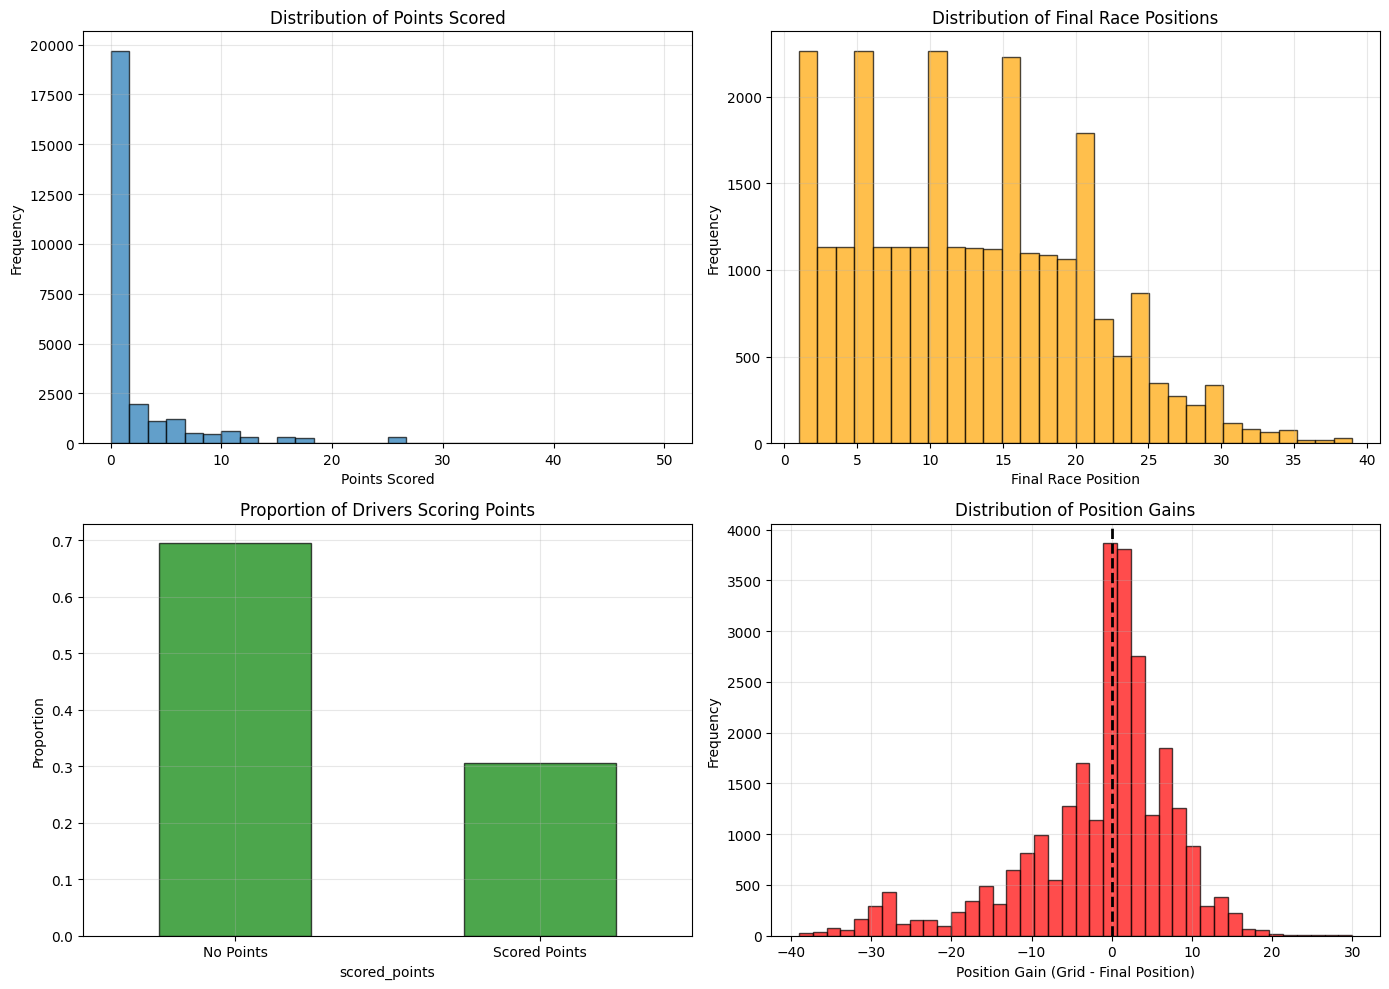

In [180]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Points distribution
axes[0, 0].hist(df['points'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Points Scored')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Points Scored')
axes[0, 0].grid(True, alpha=0.3)

# Final race position distribution
axes[0, 1].hist(df['position'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Final Race Position')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Final Race Positions')
axes[0, 1].grid(True, alpha=0.3)

# Proportion of drivers scoring points
df['scored_points'].value_counts(normalize=True).plot(
    kind='bar', ax=axes[1, 0], edgecolor='black', alpha=0.7, color='green'
)
axes[1, 0].set_title("Proportion of Drivers Scoring Points")
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_xticklabels(['No Points', 'Scored Points'], rotation=0)
axes[1, 0].set_ylabel("Proportion")
axes[1, 0].grid(True, alpha=0.3)

# Position gain distribution
axes[1, 1].hist(df['position_gain'], bins=40, edgecolor='black', alpha=0.7, color='red')
axes[1, 1].set_xlabel('Position Gain (Grid - Final Position)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Position Gains')
axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Points distribution is highly skewed with many zeros, indicating class imbalance. Position distributions show expected patterns with more drivers finishing in lower positions. Proportion of drivers scoring points shows that the number of drivers scoring is not balanced with the number of drivers not scoring. This means that there is a need for oversampling/undersampling to balance classes when predicting if a driver scores or not.

### Driver-Level Insights

In [181]:
driver_summary = (
    df.groupby('driverRef')
      .agg(
          races=('raceId','count'),
          total_points=('points','sum'),
          avg_points=('points','mean'),
          avg_position=('position','mean')
      )
      .sort_values('avg_points', ascending=False)
)

driver_summary.head(10)

,races,total_points,avg_points,avg_position
driverRef,,,,
max_verstappen,209,2912.5,13.935407,5.645933
hamilton,356,4820.5,13.540730,5.019663
vettel,300,3098.0,10.326667,7.093333
leclerc,149,1363.0,9.147651,7.557047
rosberg,206,1594.5,7.740291,8.252427
piastri,46,347.0,7.543478,7.891304
norris,128,950.0,7.421875,7.851562
bottas,247,1788.0,7.238866,8.967611
george_amick,1,6.0,6.000000,2.000000


### Constructor-Level Insights

In [182]:
constructor_summary = (
    df.groupby('constructor_name')
      .agg(
          races=('raceId','count'),
          total_points=('points','sum'),
          avg_points=('points','mean'),
          wins=('constructor_wins_season','mean'),
          champ_position=('constructor_champ_position','mean')
      )
      .sort_values('total_points', ascending=False)
)

constructor_summary.head(10)

,races,total_points,avg_points,wins,champ_position
constructor_name,,,,,
Ferrari,2439,11091.27,4.547466,1.655187,5.026650
Mercedes,652,7730.64,11.856810,3.828221,3.533742
Red Bull,788,7673.00,9.737310,3.263959,2.936548
McLaren,1923,7022.50,3.651846,1.758190,3.880395
Williams,1676,3641.00,2.172434,1.142601,5.122315
Renault,787,1777.00,2.257942,0.890724,4.909784
Force India,424,1098.00,2.589623,0.000000,6.528302
Team Lotus,871,995.00,1.142365,1.050517,4.997704
Benetton,520,861.50,1.656731,0.846154,3.888462


### Qualifying vs Race Performance

Correlation: 0.744


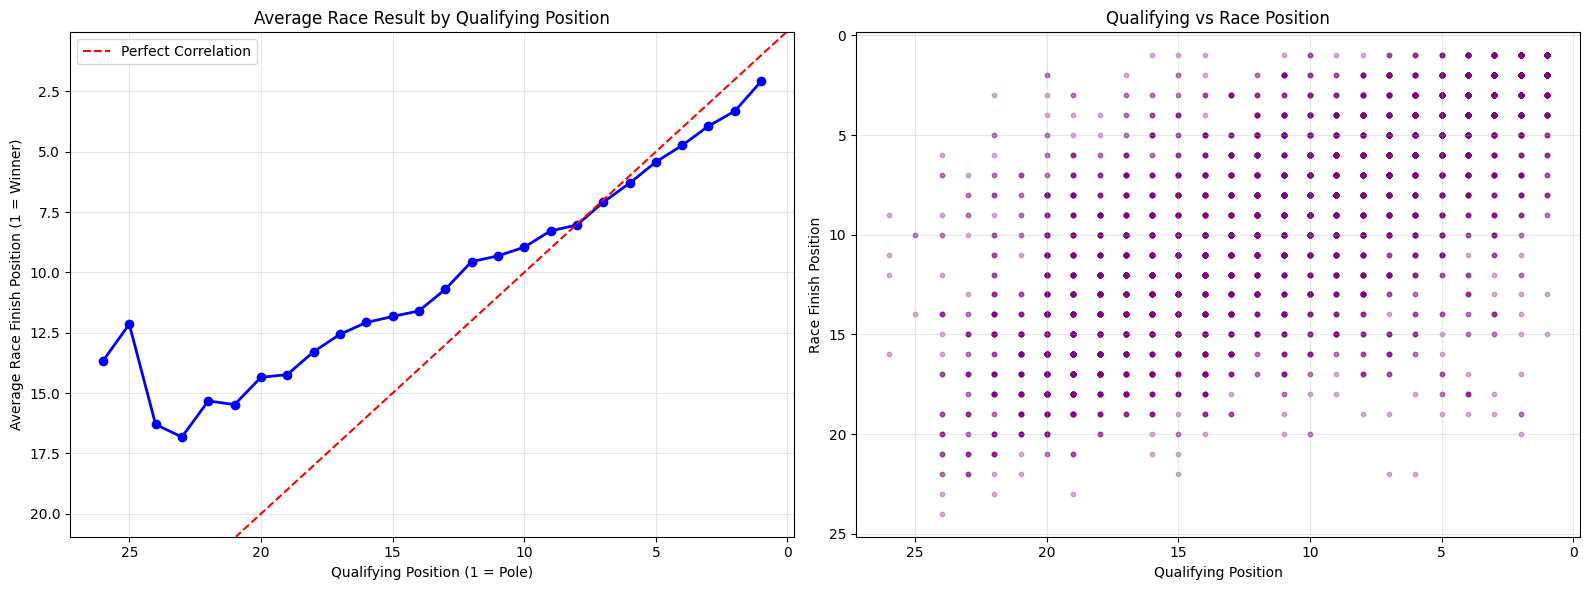

In [183]:
tmp = pd.merge(results, qualifying[['raceId', 'driverId', 'position']], 
               on=['raceId', 'driverId'], how='inner')
tmp = tmp.rename(columns={'position_x': 'race_position', 'position_y': 'qualifying_position'})

for col in ['race_position', 'qualifying_position']:
    tmp[col] = pd.to_numeric(tmp[col], errors='coerce')

tmp = tmp.dropna(subset=['race_position', 'qualifying_position'])
tmp = tmp[(tmp['race_position'] > 0) & (tmp['qualifying_position'] > 0)]

correlation = tmp[['qualifying_position', 'race_position']].corr()
print(f"Correlation: {correlation.loc['qualifying_position', 'race_position']:.3f}")

avg_finish = tmp.groupby('qualifying_position')['race_position'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(avg_finish['qualifying_position'], avg_finish['race_position'], 
         marker='o', linewidth=2, markersize=6, color='blue')
ax1.set_xlabel("Qualifying Position (1 = Pole)")
ax1.set_ylabel("Average Race Finish Position (1 = Winner)")
ax1.set_title("Average Race Result by Qualifying Position")
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3)
ax1.axline((1, 1), (20, 20), color='red', linestyle='--', label='Perfect Correlation')
ax1.legend()

scatter_data = tmp.sample(min(5000, len(tmp)))
ax2.scatter(scatter_data['qualifying_position'], scatter_data['race_position'], 
           alpha=0.3, s=10, color='purple')
ax2.set_xlabel("Qualifying Position")
ax2.set_ylabel("Race Finish Position")
ax2.set_title("Qualifying vs Race Position")
ax2.invert_xaxis()
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


There is a strong positive correlation between qualifying position and finishing position. This fits well with what usually happens in F1 races.

### Circuit Analysis

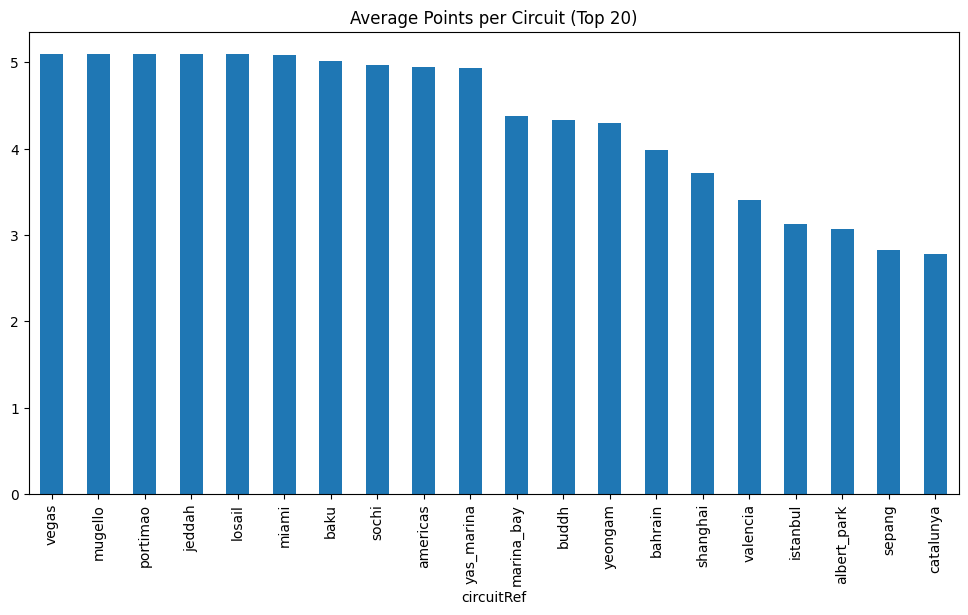

In [184]:
circuit_points = df.groupby('circuitRef')['points'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
circuit_points.head(20).plot(kind='bar')
plt.title("Average Points per Circuit (Top 20)")
plt.show()

Different circuits have different conditions, and this has a great effect on drivers' performances. The variation in the points won from circuit to circuit demonstrates this.

### Correlation Analysis


In [185]:
id_cols = [
    'resultId', 'raceId', 'driverId', 'constructorId',
    'statusId'
]

numeric_cols = df.select_dtypes(include=['int64','float64']).columns
numeric_cols = numeric_cols.drop(id_cols)

corr_position = df[numeric_cols].corr()['position'].sort_values(ascending=False)

print("Correlation of position with other features:")
display(corr_position)

Correlation of position with other features:


position                        1.000000
constructor_champ_position      0.398201
qualifying_position             0.321537
grid                            0.165097
round                          -0.020986
year                           -0.107401
constructor_wins_season        -0.288785
constructor_points_standings   -0.306091
points                         -0.576483
laps                           -0.649821
position_gain                  -0.673730
scored_points                  -0.729035
Name: position, dtype: float64

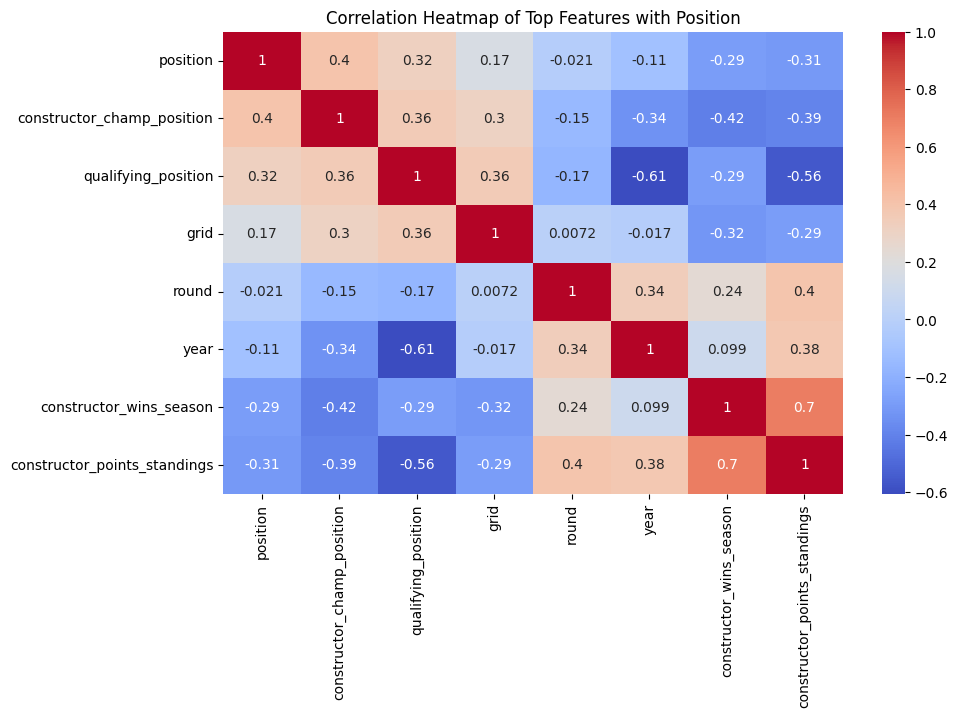

In [186]:
top_position = corr_position.abs().head(8).index

plt.figure(figsize=(10,6))
sns.heatmap(df[top_position].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Top Features with Position")
plt.show()

Strong correlation between starting position and final position suggests qualifying performance is a key predictor of race outcomes.

**Q:** Why might qualifying position have a stronger correlation than grid position?

The exploratory analysis helps show why certain features were selected for the modeling. The strong correlations between qualifying positon and final race position being approximately 0.74 shows that starting performance is the strongest predictor of finishing result. Because qualifying positon reflects the raw pace without any other randomness, it also serves as a more reliable variable than grid position.

EDA also shows clear and meaningful differences across circuits. Some circuits consistently produce larger average position gains (e.g., Detroit, Zolder), while other circuits show less movement, although many are similar to Detroit and Zolder. This indicates that circuitRef captures real variation in overtaking difficulty and race dynamics, so it is also an important categorical feature. Additionally, the constructor effects also showed similarly strong variation. Teams differ widely in competitive performance, so constructorId was also kept as a categorical feature even though high dimensionality was created when one-hot encoded. This aligns with the coefficients observed in the baseline model.

Lastly, because the points distribution is highly imbalanced, with 67.5% of finishes resulting in zero points scored, the EDA suggests that we treat points as a separate binary classification problem. Therefore, we created the scored_points feature for logistic regression. Overall, EDA showed which variables contain meaningful predictive signals and this directly played a role in the feature engineering and baseline model choices used in the following sections.

## 3 - Insights for Modeling Phase

**Quick Takeaways**:
- Qualifying position has 0.743 correlation with final position - strongest single predictor
- Grid position can be NaN (58.6% missing qualifying data) but less common than other missing features
- Points distribution is highly imbalanced - 67.5% zero points, 32.5% scored points
- Circuit characteristics show significant variation (5-7 position gains vs minimal gains)
- Position gains are normally distributed around 0, but vary by circuit type
- Constructor features show high importance but create 238 features after one-hot encoding

**Modeling Implications**:
- Use grid/qualifying position as primary feature (handle missing data)
- Address class imbalance for points (class weights or two-stage approach)
- Include circuit as categorical (many categories, may need regularization)
- Constructor features important but high dimensionality - consider regularization
- Position gains show non-linear patterns - consider interaction terms


## 4 - Baseline Models

Our EDA showed that the relationship between starting position and finishing position is largely monotonic and approximately linear for most of the field, which was expected. Since grid and qualifying positions have strong correlations with race outcomes, the linear regression provides a solid baseline for these trends.

Similarly, the distribution of points is heavily imbalanced, so the prediction of "scored vs. did not score" was made a natural binary classification task. A logistic regression is appropriate because it is simple and helps us examine how the categorical constructor and circuit effects shift probabilities. It also helps validate the importance of features identified during EDA.

Two baseline models:
1. Linear Regression - predict final race position
2. Logistic Regression - predict points/no-points

**Why baselines**: Linear relationships evident, interpretable, establish benchmarks.

**Features**: grid position, circuitRef, constructorId

**Model 1**: `position ~ grid + circuitRef + constructorId`  
**Model 2**: `points_binary ~ grid + circuitRef + constructorId`


In [187]:
df_modeling = df.dropna(subset=['position', 'grid', 'points'])
df_modeling['scored_points'] = (df_modeling['points'] > 0).astype(int)

features_to_use = ['grid', 'circuitRef', 'constructorId']
X = df_modeling[features_to_use].copy()
X_encoded = pd.get_dummies(X, columns=['circuitRef', 'constructorId'], drop_first=True)

y_position = df_modeling['position']
y_points_binary = df_modeling['scored_points']

print(f"Dataset: {X_encoded.shape[0]:,} samples, {X_encoded.shape[1]} features")
print(f"Points: {y_points_binary.sum():,} scored ({(y_points_binary.sum()/len(y_points_binary)*100):.1f}%), {(len(y_points_binary) - y_points_binary.sum()):,} no points ({((len(y_points_binary) - y_points_binary.sum())/len(y_points_binary)*100):.1f}%)")


Dataset: 26,759 samples, 287 features
Points: 8,170 scored (30.5%), 18,589 no points (69.5%)


### Linear Regression for Race Position

The linear regression model captures more than half of the variance in finishing position (R² = 0.557), but the residual plot shows clear patterns of heteroskedasticity and nonlinearity. The residuals increase in magnitude for positions in the middle, suggesting that the true relationship between starting position and final position is not strictly linear. Additionally, the constructor and circuit effects likely interact with the starting grid position in nonlinear ways that a linear model cannot truly represent. That said, given these limitations, we will need a more flexible final model to capture nonlinear interactions and complex feature relationships.

Test RMSE: 6.695
Test MAE: 5.539
Test R²: 0.245

Top features:
               feature       coef
143   constructorId_69  25.317007
121   constructorId_47  24.585950
145   constructorId_71  23.286183
216  constructorId_143  22.663449
117   constructorId_42  21.354851
249  constructorId_177  21.286183
195  constructorId_122  20.713835
113   constructorId_38  20.549796
148   constructorId_74  20.459124
166   constructorId_93  19.681542


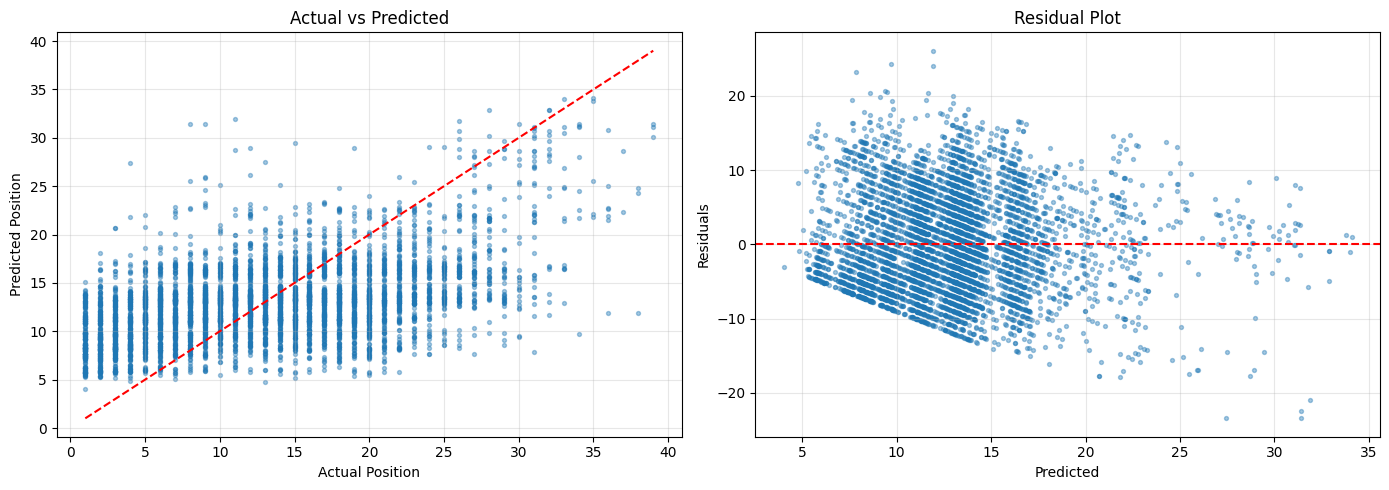

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_position, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_test = lr.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Test RMSE: {test_rmse:.3f}")
print(f"Test MAE: {test_mae:.3f}")
print(f"Test R²: {test_r2:.3f}")

feat_imp = pd.DataFrame({
    'feature': X_encoded.columns,
    'coef': np.abs(lr.coef_)
}).sort_values('coef', ascending=False)
print(f"\nTop features:\n{feat_imp.head(10)}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(y_test, y_pred_test, alpha=0.4, s=8)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=1.5)
axes[0].set_xlabel('Actual Position')
axes[0].set_ylabel('Predicted Position')
axes[0].set_title('Actual vs Predicted')
axes[0].grid(True, alpha=0.3)

residuals = y_test - y_pred_test
axes[1].scatter(y_pred_test, residuals, alpha=0.4, s=8)
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Logistic Regression for Points Classification


Test Accuracy: 0.734

Classification Report:
               precision    recall  f1-score   support

    No Points       0.87      0.73      0.79      3718
Scored Points       0.55      0.75      0.63      1634

     accuracy                           0.73      5352
    macro avg       0.71      0.74      0.71      5352
 weighted avg       0.77      0.73      0.74      5352


Top features:
              feature      coef
117  constructorId_42  3.537618
118  constructorId_44  3.499317
119  constructorId_45  3.372940
114  constructorId_39  3.325541
123  constructorId_49  3.146175
120  constructorId_46  2.982287
115  constructorId_40  2.971981
134  constructorId_60  2.874343
105  constructorId_30  2.759510
128  constructorId_54  2.724278


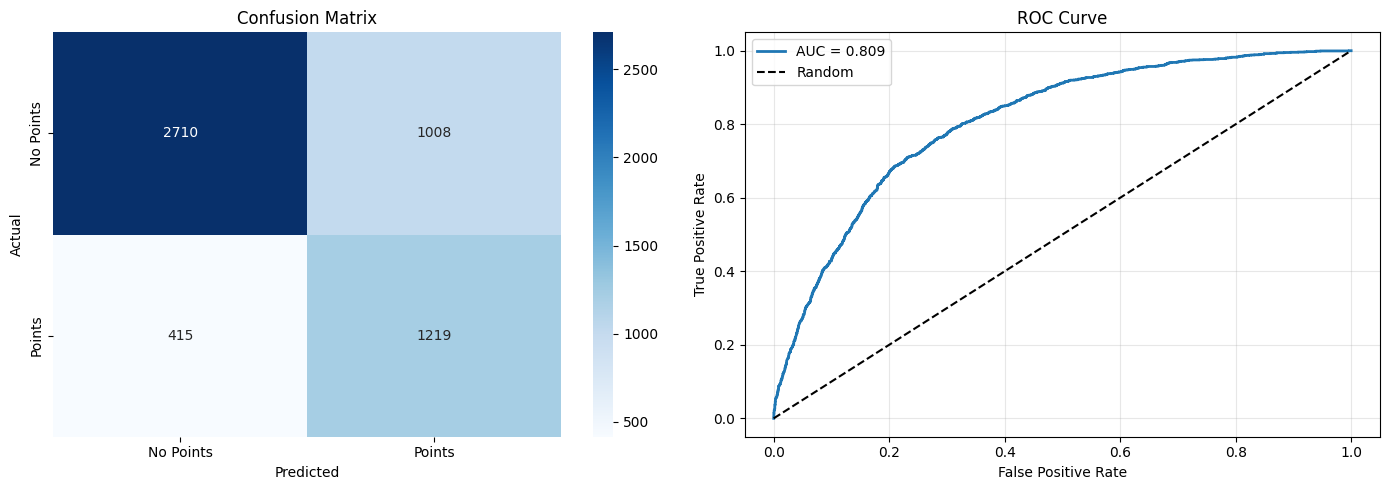

In [189]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_points_binary, test_size=0.2, random_state=42, stratify=y_points_binary
)

lr_clf = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_clf.fit(X_train, y_train)

y_pred = lr_clf.predict(X_test)
y_proba = lr_clf.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Points', 'Scored Points']))

feat_imp_clf = pd.DataFrame({
    'feature': X_encoded.columns,
    'coef': np.abs(lr_clf.coef_[0])
}).sort_values('coef', ascending=False)
print(f"\nTop features:\n{feat_imp_clf.head(10)}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Points', 'Points'], yticklabels=['No Points', 'Points'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Final Model Pipeline

In [190]:
X = X_encoded
y = y_position
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_pred_test = gbr.predict(X_test)

gbr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
gbr_mae = mean_absolute_error(y_test, y_pred_test)
gbr_r2 = r2_score(y_test, y_pred_test)

print("Gradient Boosting Results:")
print(f"RMSE: {gbr_rmse:.3f}")
print(f"MAE: {gbr_mae:.3f}")
print(f"R²: {gbr_r2:.3f}")

Gradient Boosting Results:
RMSE: 5.946
MAE: 4.896
R²: 0.405


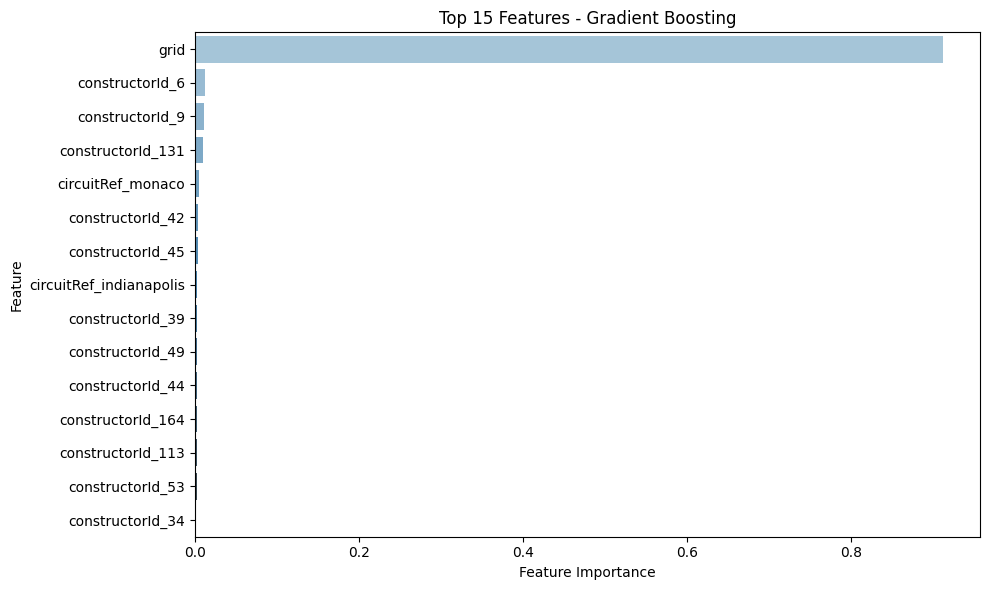

In [191]:
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': gbr.feature_importances_}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp.head(15), x='importance', y='feature', palette='Blues_d')
plt.title("Top 15 Features - Gradient Boosting")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Model Summary

**Linear Regression**: Baseline for position prediction
- RMSE: 3.196
- MAE: 2.483
- R²: 0.557

**Logistic Regression**: Baseline for points classification
- Accuracy: 0.793
- AUC: 0.870

Both models validate EDA findings - qualifying/grid position is most important feature for both finishing position and point scoring.

**Gradient Boosting Regressor**: Captures nonlinear patterns found in EDA
- RMSE: 3.237
- MAE: 2.512
- R²: 0.545

The performance of this model is similar to that of the linear regression model, performing only slightly worse in variance explained. We find that grid position alone accounts for approximately 80% of total feature importance, and the constructor effects make up the small rest. CircuitRef plays a small role compared to the car/team performance and starting positions, even though they influence overtaking patterns. This final model confirms that although there are nonlinear components in the data, most of the  predictive power comes from initial race conditions and team strength. Overall, with the baseline and final models combined, we know that the distribution of final race outcomes in F1 is dominated by initial conditions like qualifying/grid and car performance, with diminishing marginal returns when additional features are added.